# Install and import necessary libraries

In [45]:
!pip install wordcloud

     |████████████████████████████████| 160 kB 633 kB/s            
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Import and prepare data


In [2]:
# import article text

df_articles = pd.read_excel("/Users/oriold/Desktop/Masters_Contextual/articles_all_20k.xlsx")

df_articles.head(2)

,normalized_urls,headline,body
0,https://news.yahoo.com/did-nothing-wrong-famil...,'He did nothing wrong': Family of Texas entrep...,A tech entrepreneur in Texas wasn’t given ampl...
1,https://news.yahoo.com/deadline-for-real-i-ds-...,"Deadline for REAL IDs, required for domestic U...",(Photo Illustration: Jack Forbes/Yahoo News; P...


In [3]:
# join article headline and body in one single column

space = [" "]

df_articles['headline_body'] = df_articles['headline']+space+df_articles['body']


# Do a bit of data cleaning

In [4]:
import spacy
import textacy
import textacy.preprocessing as tprep
import re
import html

In [5]:
# define funtion to replace specific substrings

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

In [6]:
# define a list of words to remove that are specific to the Yahoo News corpus

words_to_remove = {'photo illustration': '','getty images': '', 'this article was originally published on': '','AFP': '',
                    'read on the fox news app': '','enjoy this content': '', 'read on the fox news app': '', 
                    'enjoy this content?': '', 'featured image via':'', 'click here to get the fox news app': '',
                    'p. m.': '', 'a. m.': '', 'u.s.': 'usa', 'u.s': 'usa', 'wpix': ''}

# define function to clean text

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # remove line breaks 
    text = re.sub('\n', '', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # Removing all the occurrences of links that starts with https
    text = re.sub(r'http\S+', '', text)
    # Remove all the occurrences of text that ends with .com
    text = re.sub(r"\ [A-Za-z]*\.com", " ", text)
    # add a space behind a dot when it's followed by something else
    text = re.sub(r'(?<=[.])(?=[^\s])', ' ', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # Convert text to lower case
    text = text.lower()
    # remove specific string for articles that are not original
    text = replace_all(text, words_to_remove)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text

In [7]:
# apply first cleaning to text 

df_articles['headline_body'] = df_articles['headline_body'].map(clean)

In [8]:
# continue normalising text by replacing hyphanated words, quotation marks and others 

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    text = tprep.replace.urls(text)
    text = tprep.replace.emails(text)
    text = tprep.replace.hashtags(text)
    text = tprep.replace.user_handles(text)
    return text

In [9]:
# apply normalisation using the function defined above 

df_articles['headline_body'] = df_articles['headline_body'].map(normalize)

In [10]:
# create a nlp object and load the english model

# Spacy will help parse the text for analysis and provide other tools like a lemmatizer

nlp = spacy.load('en_core_web_sm')

In [11]:
# check if we can work using a GPU for faster processing times

if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

Working on GPU.


In [12]:
# define functions to tokenize text

# for info on spacy's universal part-of-speech tags see
# https://universaldependencies.org/u/pos/

#define a function to extract the lemmas 

def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

# define a function to extract entities such as personal names, locations

def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc,
             include_types=include_types,
             exclude_types=None,
             drop_determiners=True,
             min_freq=1)
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]         

# define another function to put it all together (lemmas, verbs, nouns and entities)

def extract_nlp(doc):
    return {'lemmas': extract_lemmas(doc,
                                     exclude_pos=['ADP','CCONJ', 'DET', 
                                     'NUM', 'PUNCT', 'SYM', 'X']),
            'adjs_verbs': extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
            'nouns' : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
            'entities' : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC']),
            'entities_gpe' : extract_entities(doc, ['GPE']),
            'entities_person' : extract_entities(doc, ['PERSON']),
            'entities_org' : extract_entities(doc, ['ORG'])
            }

In [13]:
# define columns names for the df that's going to store all the nouns 

nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'entities', 'entities_gpe', 'entities_person', 'entities_org']


In [14]:
# initialise the new dataframe columns to fill 

for col in nlp_columns:
    df_articles[col] = None

In [15]:
# define a new NLP object 

nlp = spacy.load('en_core_web_sm', disable=[])


In [16]:
# create a new dataset to extract all the relevant values from the articles
# specify a batch size to manage articles in batches 

batch_size = 50

for i in range(0, len(df_articles), batch_size):
    docs = nlp.pipe(df_articles['headline_body'][i:i+batch_size])

    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df_articles[col].iloc[i+j] = values

In [17]:
# visualize the new dataset with the text features extracted

df_articles.head(2)

,normalized_urls,headline,body,headline_body,lemmas,adjs_verbs,nouns,entities,entities_gpe,entities_person,entities_org
0,https://news.yahoo.com/did-nothing-wrong-famil...,'He did nothing wrong': Family of Texas entrep...,A tech entrepreneur in Texas wasn’t given ampl...,'he did nothing wrong': family of texas entrep...,"[wrong, family, texas, entrepreneur, fatally, ...","[wrong, shoot, defend, give, ample, drop, carr...","[family, texas, entrepreneur, police, home, te...","[texas/GPE, texas/GPE, nbc_news/ORG, austin/PE...","[texas/GPE, texas/GPE, texas/GPE, sanchez/GPE]","[austin/PERSON, ruth/PERSON, austin/PERSON, au...",[nbc_news/ORG]
1,https://news.yahoo.com/deadline-for-real-i-ds-...,"Deadline for REAL IDs, required for domestic U...",(Photo Illustration: Jack Forbes/Yahoo News; P...,"deadline for real ids, required for domestic u...","[deadline, real, id, require, domestic, u., s....","[real, require, domestic, universal, universal...","[deadline, id, u., s., travel, month, jack, fo...","[u._s._travel/PERSON, jack_forbes/PERSON, yaho...","[california/GPE, united_states/GPE, west_palm_...","[u._s._travel/PERSON, jack_forbes/PERSON, s._w...","[yahoo_news/ORG, nicholson/ORG, department_of_..."


In [22]:
# define function to count words 

from collections import Counter

def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)


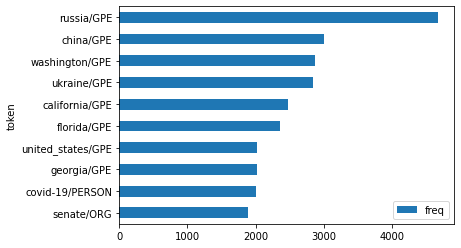

In [23]:
# display chart with most common entities 

count_words(df_articles, 'entities').head(10).plot(kind='barh').invert_yaxis()


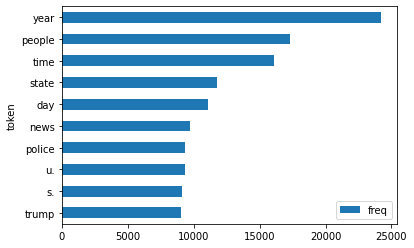

In [24]:
# display chart with most common entities 

count_words(df_articles, 'nouns').head(10).plot(kind='barh').invert_yaxis()


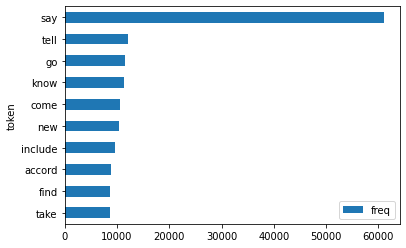

In [25]:
# display chart with most common entities 

count_words(df_articles, 'adjs_verbs').head(10).plot(kind='barh').invert_yaxis()


# Continue importing data

In [26]:
# import classified article data 

df_segments = pd.read_excel("/Users/oriold/Desktop/Masters_Contextual/urls_classified_segment_name_segment_flag.xlsx")

df_segments.head(2)

,Unnamed: 0,normalized_url,taxonomy_id,taxonomy_name,segment_id,segment_name,flag
0,0,https://news.yahoo.com,23,GrapeshotBrandSafetyTaxononomy,50436682,Legacy Custom Shell Keywords,safe
1,1,https://news.yahoo.com,11,IASBrandSafetyTaxonomyId,50260103,Exclude content rated as HIGH RISK for Violenc...,unsafe


In [27]:
#drop unnecessary columns from df_classified 

df_segments = df_segments[['normalized_url', 'taxonomy_name', 'segment_id', 'segment_name', 'flag']]

df_segments.head(2)

,normalized_url,taxonomy_name,segment_id,segment_name,flag
0,https://news.yahoo.com,GrapeshotBrandSafetyTaxononomy,50436682,Legacy Custom Shell Keywords,safe
1,https://news.yahoo.com,IASBrandSafetyTaxonomyId,50260103,Exclude content rated as HIGH RISK for Violenc...,unsafe


In [28]:
df_articles = df_articles.rename(columns={'normalized_urls': 'normalized_url'})

In [29]:
# merge article text and segment df

df_segments = pd.merge(df_segments,
                        df_articles,
                        on = 'normalized_url',
                        how = 'left')

df_segments.head(2)                        

,normalized_url,taxonomy_name,segment_id,segment_name,flag,headline,body,headline_body,lemmas,adjs_verbs,nouns,entities,entities_gpe,entities_person,entities_org
0,https://news.yahoo.com,GrapeshotBrandSafetyTaxononomy,50436682,Legacy Custom Shell Keywords,safe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://news.yahoo.com,IASBrandSafetyTaxonomyId,50260103,Exclude content rated as HIGH RISK for Violenc...,unsafe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# import classified article data 

df_classified = pd.read_excel("/Users/oriold/Desktop/Masters_Contextual/unique_urls_classified_1203.xlsx")

df_classified.head(2)

,Unnamed: 0,unique_urls,IAS_GS_unsafe_flag,GS_DV_unsafe_flag,IAS_DV_unsafe_flag,IAS_unsafe_flag,GS_unsafe_flag,DV_unsafe_flag,headline,page_uuid,content_views
0,0,https://news.yahoo.com,unsafe,unsafe,unsafe,unsafe,unsafe,unsafe,NaN,NaN,NaN
1,1,https://news.yahoo.com/,unsafe,unsafe,unsafe,unsafe,unsafe,unsafe,NaN,NaN,NaN


In [31]:
#keep only columns that matter from classified 

df_classified = df_classified.rename(columns={'unique_urls': 'normalized_url'})

df_classified = df_classified[['normalized_url', 'content_views', 'IAS_GS_unsafe_flag','GS_DV_unsafe_flag','IAS_DV_unsafe_flag','IAS_unsafe_flag','GS_unsafe_flag','DV_unsafe_flag']]


In [32]:
# merge article text and segment df

df_segments = pd.merge(df_segments,
                        df_classified,
                        on = 'normalized_url',
                        how = 'left')

df_segments.head(2)        

,normalized_url,taxonomy_name,segment_id,segment_name,flag,headline,body,headline_body,lemmas,adjs_verbs,...,entities_gpe,entities_person,entities_org,content_views,IAS_GS_unsafe_flag,GS_DV_unsafe_flag,IAS_DV_unsafe_flag,IAS_unsafe_flag,GS_unsafe_flag,DV_unsafe_flag
0,https://news.yahoo.com,GrapeshotBrandSafetyTaxononomy,50436682,Legacy Custom Shell Keywords,safe,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,unsafe,unsafe,unsafe,unsafe,unsafe,unsafe
1,https://news.yahoo.com,IASBrandSafetyTaxonomyId,50260103,Exclude content rated as HIGH RISK for Violenc...,unsafe,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,unsafe,unsafe,unsafe,unsafe,unsafe,unsafe


In [33]:
df_segments = df_segments.sort_values(by='content_views', ascending=False)

df_segments.head(2)

,normalized_url,taxonomy_name,segment_id,segment_name,flag,headline,body,headline_body,lemmas,adjs_verbs,...,entities_gpe,entities_person,entities_org,content_views,IAS_GS_unsafe_flag,GS_DV_unsafe_flag,IAS_DV_unsafe_flag,IAS_unsafe_flag,GS_unsafe_flag,DV_unsafe_flag
137865,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260090,Exclude content rated as HIGH RISK for Drug Co...,unsafe,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe
137860,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260104,Exclude content rated as HIGH or MODERATE RISK...,unsafe,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe


In [34]:
# import revenue data

df_revenue = pd.read_csv("/Users/oriold/Desktop/Masters_Contextual/december_2022_raw_data/maw_summary v_merged_revenue 2023-01-05T1850.csv")

df_revenue.head(2)

,Title,Canonical URL,Page Content UUID,Display Revenue
0,'He did nothing wrong': Family of Texas entrep...,https://news.yahoo.com/did-nothing-wrong-famil...,8d0dc70c-83ca-3032-bd4b-7a51d0c47d18,8605.19
1,"Deadline for REAL IDs, required for domestic U...",https://news.yahoo.com/deadline-for-real-i-ds-...,870b1a79-8072-4cbb-83ce-31e2529d601a,3758.81


In [35]:
#keep only columns that matter 

df_revenue = df_revenue[['Canonical URL', 'Display Revenue']]

#rename column UUID 

df_revenue = df_revenue.rename(columns={'Canonical URL': 'normalized_url', 'Display Revenue': 'display_revenue'})

In [36]:
#merge flags into the unique url dataframe 

df = pd.merge(df_segments, 
              df_revenue, 
              on = 'normalized_url',
              how = 'left')

df.head(2)

,normalized_url,taxonomy_name,segment_id,segment_name,flag,headline,body,headline_body,lemmas,adjs_verbs,...,entities_person,entities_org,content_views,IAS_GS_unsafe_flag,GS_DV_unsafe_flag,IAS_DV_unsafe_flag,IAS_unsafe_flag,GS_unsafe_flag,DV_unsafe_flag,display_revenue
0,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260090,Exclude content rated as HIGH RISK for Drug Co...,unsafe,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe,3.56
1,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260104,Exclude content rated as HIGH or MODERATE RISK...,unsafe,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe,3.56


In [37]:
df.dtypes

normalized_url         object
taxonomy_name          object
segment_id              int64
segment_name           object
flag                   object
headline               object
body                   object
headline_body          object
lemmas                 object
adjs_verbs             object
nouns                  object
entities               object
entities_gpe           object
entities_person        object
entities_org           object
content_views          object
IAS_GS_unsafe_flag     object
GS_DV_unsafe_flag      object
IAS_DV_unsafe_flag     object
IAS_unsafe_flag        object
GS_unsafe_flag         object
DV_unsafe_flag         object
display_revenue       float64
dtype: object

In [38]:
# remove comma from 'content_views' column
df['content_views'] = df['content_views'].str.replace(',', '')

# replace NaN values with 0
df['content_views'] = df['content_views'].fillna('0')

# convert 'content_views' column from object to integer
df['content_views'] = df['content_views'].astype(int)


In [39]:
# calculate yield by article 

df['yield_cpm'] = df['display_revenue']/df['content_views']*1000

df.head(2)

,normalized_url,taxonomy_name,segment_id,segment_name,flag,headline,body,headline_body,lemmas,adjs_verbs,...,entities_org,content_views,IAS_GS_unsafe_flag,GS_DV_unsafe_flag,IAS_DV_unsafe_flag,IAS_unsafe_flag,GS_unsafe_flag,DV_unsafe_flag,display_revenue,yield_cpm
0,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260090,Exclude content rated as HIGH RISK for Drug Co...,unsafe,NaN,NaN,NaN,NaN,NaN,...,NaN,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe,3.56,3.567134
1,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260104,Exclude content rated as HIGH or MODERATE RISK...,unsafe,NaN,NaN,NaN,NaN,NaN,...,NaN,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe,3.56,3.567134


# Start EDA

In [40]:
df.shape

(390333, 24)

In [41]:
#delete all rows that don't have revenue data associated 

df_eda = df.dropna(axis=0, subset=['display_revenue'])

df_eda.shape

(61051, 24)

Analyse the most common words by unsafe categories for IAS

In [42]:
#filter data to look at IAS only 

df_ias = df.loc[(df['taxonomy_name']=='IASBrandSafetyTaxonomyId') & (df['flag']=='unsafe')]

df_ias['segment_name_simplified'] = np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Drug Content','Drug Content',
                                    np.where(df_ias['segment_name']=='Exclude content that CANNOT BE RATED (i.e. blind urls, ad server urls, ad network urls, doubleclick.net, yieldmanager.com, ip addresses, etc.)','Cannot be rated',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Alcohol Content','Alcohol Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Offensive Language Content','Offensive Language Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Violence in Video','Violence in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Violence','Violence',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Adult Content','Adult Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Violence in Video','Violence in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Illegal Download Content','Illegal Download Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Adult Content in Video','Adult Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Illegal Download Content in Video','Illegal Download Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Alcohol Content in Video','Alcohol Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Illegal Download Content in Video','Illegal Download Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Drug Content in Video','Drug Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Hate Speech Content','Hate Speech Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Hate Speech Content','Hate Speech Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Hate Speech Content in Video','Hate Speech Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Hate Speech Content in Video','Hate Speech Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Offensive Language Content in Video','Offensive Language Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Illegal Download Content','Illegal Download Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Violence','Violence',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Drug Content','Drug Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Adult Content','Adult Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Suspicious Activity in Video','Suspicious Activity in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Adult Content in Video','Adult Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content that CANNOT BE RATED (i.e. blind urls, ad server urls, ad network urls, doubleclick.net, yieldmanager.com, ip addresses, etc.) in Video','Cannot be rated',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Suspicious Activity','Suspicious Activity',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Suspicious Activity','Suspicious Activity',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Offensive Language Content','Offensive Language Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Drug Content in Video','Drug Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Alcohol Content','Alcohol Content',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Suspicious Activity in Video','Suspicious Activity in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Alcohol Content in Video','Alcohol Content in Video',
                                    np.where(df_ias['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Offensive Language Content in Video','Offensive Language Content in Video','else'))))))))))))))))))))))))))))))))))

/var/folders/dj/h6m1714d6p510xvgy0_f10cm0000gq/T/ipykernel_88360/1268997474.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ias['segment_name_simplified'] = np.where(df_ias['segment_name']=='Exclude content rated as HIGH RISK for Drug Content','Drug Content',


In [43]:
df_ias_segments = df_ias.groupby('segment_name_simplified').apply(lambda x: x['display_revenue'].sum()/x['content_views'].sum()*100)

#transform to dataframe

df_ias_segments = pd.DataFrame(df_ias_segments)

# format the df

df_ias_segments.columns = df_ias_segments.columns.to_flat_index()

df_ias_segments = df_ias_segments.reset_index()

df_ias_segments = df_ias_segments.rename(columns={0: 'yield'})

df_ias_segments['yield'] = df_ias_segments['yield'].round(2)

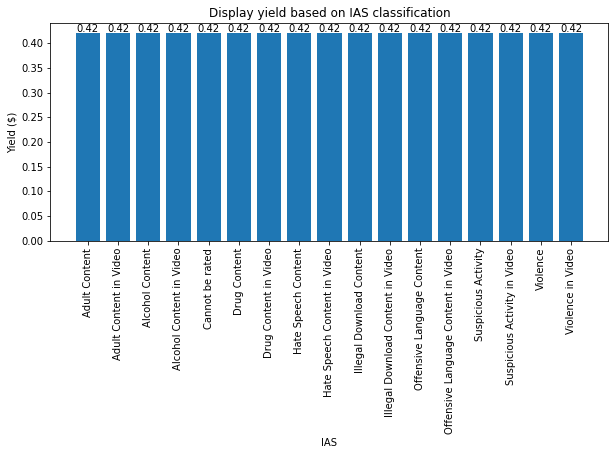

In [44]:
#define a function to show the yield differences by brand safety category 

x = df_ias_segments['segment_name_simplified']

y = df_ias_segments["yield"]

def yield_chart(x, y, vendor):
    fig, ax = plt.subplots(figsize=(10,4))
    #bar_colors = ["green", "salmon"]
    ax.set_title("Display yield based on {} classification".format(vendor))
    p1 = ax.bar(x, y, label = x.values)
    ax.bar_label(p1)
    ax.set_xlabel("{}".format(vendor))
    ax.set_ylabel("Yield ($)")
    plt.xticks(rotation=90)

yield_chart(x, y, "IAS")

In [45]:
# count occurrences a particular column
df_ias_segments = df_ias.groupby(['segment_name_simplified']).size()

print(type(df_ias_segments))

print(df_ias_segments.index)

<class 'pandas.core.series.Series'>
Index(['Adult Content', 'Adult Content in Video', 'Alcohol Content',
       'Alcohol Content in Video', 'Cannot be rated', 'Drug Content',
       'Drug Content in Video', 'Hate Speech Content',
       'Hate Speech Content in Video', 'Illegal Download Content',
       'Illegal Download Content in Video', 'Offensive Language Content',
       'Offensive Language Content in Video', 'Suspicious Activity',
       'Suspicious Activity in Video', 'Violence', 'Violence in Video'],
      dtype='object', name='segment_name_simplified')


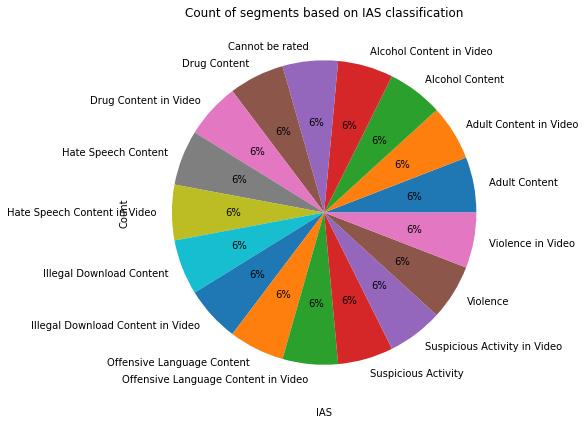

In [46]:
# count occurrences a particular column
df_ias_segments = df_ias.groupby(['segment_name_simplified']).size()

x = df_ias_segments

labels = df_ias_segments.index

def count_chart(x, vendor):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title("Count of segments based on {} classification".format(vendor))
    ax.pie(x, labels=labels, autopct='%.0f%%')
    ax.set_xlabel("{}".format(vendor))
    ax.set_ylabel("Count")
    #plt.xticks(rotation=45)

count_chart(x, "IAS")

Analyse the most common words by unsafe categories for GS

In [47]:
#filter data to look at GS only 

df_gs = df.loc[(df['taxonomy_name']=='GrapeshotBrandSafetyTaxononomy') & (df['flag']=='unsafe')]

df_gs['segment_name_simplified'] = np.where(df_gs['segment_name']=='gv_crime (block) - Crime (including crime, violence)','Crime',
                                    np.where(df_gs['segment_name']=='gv_death_injury (block) - Death & Injury (including death, injury, accidents, disasters) ','Death_and_Injury',
                                    np.where(df_gs['segment_name']=='gv_arms (block) - Arms (including arms, guns, weapons)','Arms',
                                    np.where(df_gs['segment_name']=='gv_military (block) - Military (including military, armed forces, weapons, wars, conflicts)','Military',
                                    np.where(df_gs['segment_name']=='gv_terrorism (block) - Terrorism (including terrorists, terrorists groups, terrorist activity)','Terrorism',
                                    np.where(df_gs['segment_name']=='gv_adult (block) - Adult (including adult content, pornography, sexually explicit material) ','Adult',
                                    np.where(df_gs['segment_name']=='gv_hatespeech (block) - Hatespeech (including hatespeech, racism, racist groups, racist terms)','Hatespeech',
                                    np.where(df_gs['segment_name']=='gv_drugs (block) - Drugs (including illegal drugs) ','Drugs',
                                    np.where(df_gs['segment_name']=='gv_obscenity (block) - Obscenity (including obscene terms, swear words)','Obscenity',
                                    np.where(df_gs['segment_name']=='gv_tobacco (block) - Tobacco (including tobacco products)','Tobacco',
                                    np.where(df_gs['segment_name']=='gv_death_injury (block) - Death & Injury (including death, injury, accidents, disasters)','Death_and_Injury',
                                    np.where(df_gs['segment_name']=='gv_adult (block) - Adult (including adult content, pornography, sexually explicit material)','Adult',
                                    np.where(df_gs['segment_name']=='gv_drugs (block) - Drugs (including illegal drugs)','Drugs','else')))))))))))))

/var/folders/dj/h6m1714d6p510xvgy0_f10cm0000gq/T/ipykernel_88360/1572448375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gs['segment_name_simplified'] = np.where(df_gs['segment_name']=='gv_crime (block) - Crime (including crime, violence)','Crime',


In [48]:


df_gs_segments = df_gs.groupby('segment_name_simplified').apply(lambda x: x['display_revenue'].sum()/x['content_views'].sum()*100)

#transform to dataframe

df_gs_segments = pd.DataFrame(df_gs_segments)

# format the df

df_gs_segments.columns = df_gs_segments.columns.to_flat_index()

df_gs_segments = df_gs_segments.reset_index()

df_gs_segments = df_gs_segments.rename(columns={0: 'yield'})

df_gs_segments['yield'] = df_gs_segments['yield'].round(2)

df_gs_segments = df_gs_segments.sort_values(by='yield', ascending=False)

#filter segments to look at standard segments only 

#gs_standard_segments = ['gv_arms (block) - Arms (including arms, guns, weapons)',
#'gv_obscenity (block) - Obscenity (including obscene terms, swear words)',
#'gv_tobacco (block) - Tobacco (including tobacco products)',
#'gv_hatespeech (block) - Hatespeech (including hatespeech, racism, racist groups, racist terms)',
#'gv_drugs (block) - Drugs (including illegal drugs)',
#'gv_military (block) - Military (including military, armed forces, weapons, wars, conflicts)',
#'gv_adult (block) - Adult (including adult content, pornography, sexually explicit material)',
#'gv_crime (block) - Crime (including crime, violence)',
#'gv_death_injury (block) - Death & Injury (including death, injury, accidents, disasters)',
#'gv_terrorism (block) - Terrorism (including terrorists, terrorists groups, terrorist activity)']

#filter = df_gs_segments['segment_name'].isin(gs_standard_segments)

#df_gs_segments = df_gs_segments[filter]

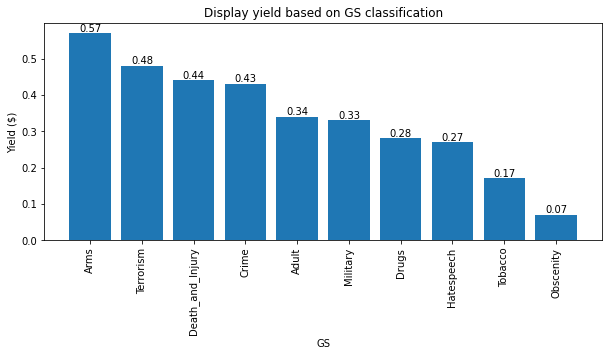

In [49]:
#see yield by segment

x = df_gs_segments['segment_name_simplified']

y = df_gs_segments["yield"]

yield_chart(x, y, "GS")

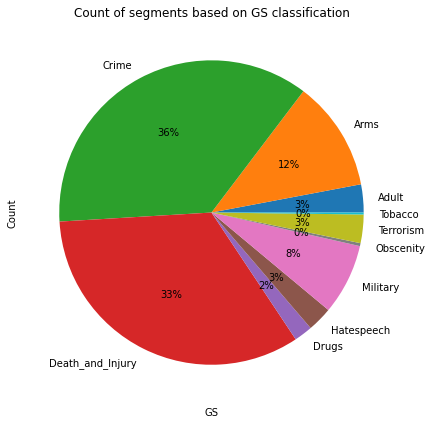

In [50]:
# count occurrences a particular column
df_gs_segments = df_gs.groupby(['segment_name_simplified']).size()

# plot pie chart 

x = df_gs_segments

labels = df_gs_segments.index

count_chart(x, "GS")


Analyse the most common words by unsafe categories for DV

In [51]:
#filter data to look at DV only 

df_dv = df.loc[(df['taxonomy_name']=='DoubleVerifyAvoidanceCategoriesTaxonomyId') & (df['flag']=='unsafe')]

df_dv['segment_name_simplified'] = np.where(df_dv['segment_name']=='Crime - High, Medium & Low Risk','Crime',
                                    np.where(df_dv['segment_name']=='Death & Injuries - High, Medium & Low Risk','Death & Injuries',
                                    np.where(df_dv['segment_name']=='Crime - High & Medium Risk','Crime',
                                    np.where(df_dv['segment_name']=='Violence - High, Medium & Low Risk','Violence',
                                    np.where(df_dv['segment_name']=='Death & Injuries - High & Medium Risk','Death & Injuries',
                                    np.where(df_dv['segment_name']=='Violence - High & Medium Risk','Violence',
                                    np.where(df_dv['segment_name']=='Celebrity Gossip','Celebrity Gossip',
                                    np.where(df_dv['segment_name']=='Human-made Disasters - High, Medium & Low Risk','Human-made_disasters',
                                    np.where(df_dv['segment_name']=='Hate Speech & Cyberbullying - High, Medium & Low Risk','Hate Speech & Cyberbullying',
                                    np.where(df_dv['segment_name']=='Hate Speech & Cyberbullying - High & Medium Risk','Hate Speech & Cyberbullying',
                                    np.where(df_dv['segment_name']=='Human-made Disasters - High & Medium Risk','Human-made_disasters',
                                    np.where(df_dv['segment_name']=='Natural Disasters - High, Medium & Low Risk','Natural Disasters',
                                    np.where(df_dv['segment_name']=='Negative News: Financial','Negative News: Financial',
                                    np.where(df_dv['segment_name']=='Natural Disasters - High & Medium Risk','Natural Disasters',
                                    np.where(df_dv['segment_name']=='Adult & Sexual - High, Medium & Low Risk','Adult & Sexual',
                                    np.where(df_dv['segment_name']=='Adult & Sexual - High & Medium Risk','Adult & Sexual',
                                    np.where(df_dv['segment_name']=='Drug Abuse - High, Medium & Low Risk','Drug Abuse',
                                    np.where(df_dv['segment_name']=='Vehicle Disasters - High, Medium & Low Risk','Vehicle Disasters',
                                    np.where(df_dv['segment_name']=='Drug Abuse - High & Medium Risk','Drug Abuse',
                                    np.where(df_dv['segment_name']=='Vehicle Disasters - High & Medium Risk','Vehicle Disasters',
                                    np.where(df_dv['segment_name']=='Alcohol - High, Medium & Low Risk','Alcohol',
                                    np.where(df_dv['segment_name']=='Terrorism - High, Medium & Low Risk','Terrorism',
                                    np.where(df_dv['segment_name']=='Terrorism - High & Medium Risk','Terrorism',
                                    np.where(df_dv['segment_name']=='Alcohol - High & Medium Risk','Alcohol',
                                    np.where(df_dv['segment_name']=='Aviation Disasters - High & Medium Risk','Aviation Disasters',
                                    np.where(df_dv['segment_name']=='Aviation Disasters - High, Medium & Low Risk','Aviation Disasters',
                                    np.where(df_dv['segment_name']=='Negative News: Pharmaceutical','Negative News: Pharmaceutical',
                                    np.where(df_dv['segment_name']=='Occult','Occult',
                                    np.where(df_dv['segment_name']=='All Severe Content','All Severe Content',
                                    np.where(df_dv['segment_name']=='Hate Speech & Cyberbullying - High Risk','Hate Speech & Cyberbullying',
                                    np.where(df_dv['segment_name']=='Profanity - High & Medium Risk','Profanity',
                                    np.where(df_dv['segment_name']=='Profanity - High, Medium & Low Risk','Profanity',
                                    np.where(df_dv['segment_name']=='Gambling','Gambling',
                                    np.where(df_dv['segment_name']=='Tobacco & eCigarettes - High & Medium Risk','Tobacco & eCigarettes',
                                    np.where(df_dv['segment_name']=='Tobacco & eCigarettes - High, Medium & Low Risk','Tobacco & eCigarettes',
                                    np.where(df_dv['segment_name']=='Violence - High Risk','Violence','else'))))))))))))))))))))))))))))))))))))

/var/folders/dj/h6m1714d6p510xvgy0_f10cm0000gq/T/ipykernel_88360/1598918448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dv['segment_name_simplified'] = np.where(df_dv['segment_name']=='Crime - High, Medium & Low Risk','Crime',


In [52]:
df_dv_segments = df_dv.groupby('segment_name_simplified').apply(lambda x: x['display_revenue'].sum()/x['content_views'].sum()*100)

#transform to dataframe

df_dv_segments = pd.DataFrame(df_dv_segments)

# format the df

df_dv_segments.columns = df_dv_segments.columns.to_flat_index()

df_dv_segments = df_dv_segments.reset_index()

df_dv_segments = df_dv_segments.rename(columns={0: 'yield'})

df_dv_segments['yield'] = df_dv_segments['yield'].round(2)

df_dv_segments = df_dv_segments.sort_values(by='yield', ascending=False)

/var/folders/dj/h6m1714d6p510xvgy0_f10cm0000gq/T/ipykernel_88360/4172710197.py:1: RuntimeWarning: invalid value encountered in double_scalars
  df_dv_segments = df_dv.groupby('segment_name_simplified').apply(lambda x: x['display_revenue'].sum()/x['content_views'].sum()*100)


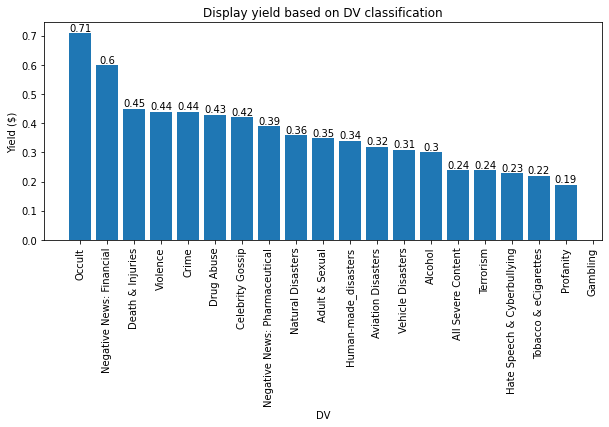

In [53]:
#see yield by segment

#x = df_dv_segments['segment_name_simplified'].loc[df_dv_segments['segment_name_simplified']!='else']

x = df_dv_segments['segment_name_simplified']

y = df_dv_segments["yield"]

yield_chart(x, y, "DV")

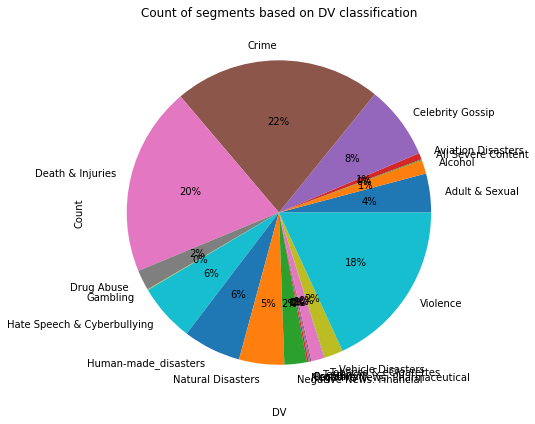

In [54]:
# count occurrences a particular column
df_dv_segments = df_dv.groupby(['segment_name_simplified']).size()

# plot pie chart 

x = df_dv_segments

labels = df_dv_segments.index

count_chart(x, "DV")


Understand most common words in articles flagged as unsafe, starting with GS

In [55]:
#define unifed segment names

df['segment_name_simplified'] = np.where(df['segment_name']=='Crime - High, Medium & Low Risk','Crime',
np.where(df['segment_name']=='Death & Injuries - High, Medium & Low Risk','Death_and_Injury',
np.where(df['segment_name']=='Crime - High & Medium Risk','Crime',
np.where(df['segment_name']=='Violence - High, Medium & Low Risk','Violence',
np.where(df['segment_name']=='Death & Injuries - High & Medium Risk','Death_and_Injury',
np.where(df['segment_name']=='Violence - High & Medium Risk','Violence',
np.where(df['segment_name']=='Celebrity Gossip','Celebrity Gossip',
np.where(df['segment_name']=='Human-made Disasters - High, Medium & Low Risk','Human-made_Disasters',
np.where(df['segment_name']=='Hate Speech & Cyberbullying - High, Medium & Low Risk','Hatespeech',
np.where(df['segment_name']=='Hate Speech & Cyberbullying - High & Medium Risk','Hatespeech',
np.where(df['segment_name']=='Human-made Disasters - High & Medium Risk','Human-made_Disasters',
np.where(df['segment_name']=='Natural Disasters - High, Medium & Low Risk','Natural Disasters',
np.where(df['segment_name']=='Negative News: Financial','Negative News: Financial',
np.where(df['segment_name']=='Natural Disasters - High & Medium Risk','Natural Disasters',
np.where(df['segment_name']=='Adult & Sexual - High, Medium & Low Risk','Adult',
np.where(df['segment_name']=='Adult & Sexual - High & Medium Risk','Adult',
np.where(df['segment_name']=='Drug Abuse - High, Medium & Low Risk','Drugs',
np.where(df['segment_name']=='Vehicle Disasters - High, Medium & Low Risk','Vehicle Disasters',
np.where(df['segment_name']=='Drug Abuse - High & Medium Risk','Drugs',
np.where(df['segment_name']=='Vehicle Disasters - High & Medium Risk','Vehicle Disasters',
np.where(df['segment_name']=='Alcohol - High, Medium & Low Risk','Alcohol',
np.where(df['segment_name']=='Terrorism - High, Medium & Low Risk','Terrorism',
np.where(df['segment_name']=='Terrorism - High & Medium Risk','Terrorism',
np.where(df['segment_name']=='Alcohol - High & Medium Risk','Alcohol',
np.where(df['segment_name']=='Aviation Disasters - High & Medium Risk','Aviation Disasters',
np.where(df['segment_name']=='Aviation Disasters - High, Medium & Low Risk','Aviation Disasters',
np.where(df['segment_name']=='Negative News: Pharmaceutical','Negative News: Pharmaceutical',
np.where(df['segment_name']=='Occult','Occult',
np.where(df['segment_name']=='All Severe Content','All Severe Content',
np.where(df['segment_name']=='Hate Speech & Cyberbullying - High Risk','Hatespeech',
np.where(df['segment_name']=='Profanity - High & Medium Risk','Profanity',
np.where(df['segment_name']=='Profanity - High, Medium & Low Risk','Profanity',
np.where(df['segment_name']=='Gambling','Gambling',
np.where(df['segment_name']=='Tobacco & eCigarettes - High & Medium Risk','Tobacco',
np.where(df['segment_name']=='Tobacco & eCigarettes - High, Medium & Low Risk','Tobacco',
np.where(df['segment_name']=='Violence - High Risk','Violence',
np.where(df['segment_name']=='gv_crime (block) - Crime (including crime, violence)','Crime',
np.where(df['segment_name']=='gv_death_injury (block) - Death & Injury (including death, injury, accidents, disasters) ','Death_and_Injury',
np.where(df['segment_name']=='gv_arms (block) - Arms (including arms, guns, weapons)','Arms',
np.where(df['segment_name']=='gv_military (block) - Military (including military, armed forces, weapons, wars, conflicts)','Military',
np.where(df['segment_name']=='gv_terrorism (block) - Terrorism (including terrorists, terrorists groups, terrorist activity)','Terrorism',
np.where(df['segment_name']=='gv_adult (block) - Adult (including adult content, pornography, sexually explicit material) ','Adult',
np.where(df['segment_name']=='gv_hatespeech (block) - Hatespeech (including hatespeech, racism, racist groups, racist terms)','Hatespeech',
np.where(df['segment_name']=='gv_drugs (block) - Drugs (including illegal drugs) ','Drugs',
np.where(df['segment_name']=='gv_obscenity (block) - Obscenity (including obscene terms, swear words)','Obscenity',
np.where(df['segment_name']=='gv_tobacco (block) - Tobacco (including tobacco products)','Tobacco',
np.where(df['segment_name']=='Exclude content that CANNOT BE RATED (i.e. blind urls, ad server urls, ad network urls, doubleclick.net, yieldmanager.com, ip addresses, etc.)','Cannot be rated',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Alcohol Content','Alcohol',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Offensive Language Content','Offensive Language',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Violence in Video','Violence',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Violence','Violence',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Adult Content','Adult',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Violence in Video','Violence',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Illegal Download Content','Illegal Download',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Adult Content in Video','Adult',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Illegal Download Content in Video','Illegal Download',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Alcohol Content in Video','Alcohol',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Illegal Download Content in Video','Illegal Download',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Drug Content in Video','Drugs',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Hate Speech Content','Hatespeech',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Hate Speech Content','Hatespeech',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Hate Speech Content in Video','Hatespeech',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Hate Speech Content in Video','Hatespeech',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Offensive Language Content in Video','Offensive Language',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Illegal Download Content','Illegal Download',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Violence','Violence',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Drug Content','Drugs',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Adult Content','Adult',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Suspicious Activity in Video','Suspicious Activity',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Adult Content in Video','Adult',
np.where(df['segment_name']=='Exclude content that CANNOT BE RATED (i.e. blind urls, ad server urls, ad network urls, doubleclick.net, yieldmanager.com, ip addresses, etc.) in Video','Cannot be rated',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Suspicious Activity','Suspicious Activity',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Suspicious Activity','Suspicious Activity',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Offensive Language Content','Offensive Language',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Drug Content in Video','Drugs',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Alcohol Content','Alcohol',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Suspicious Activity in Video','Suspicious Activity',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Alcohol Content in Video','Alcohol',
np.where(df['segment_name']=='Exclude content rated as HIGH or MODERATE RISK for Offensive Language Content in Video','Offensive Language',
np.where(df['segment_name']=='Exclude content rated as HIGH RISK for Drug Content','Drugs',
np.where(df['segment_name']=='gv_death_injury (block) - Death & Injury (including death, injury, accidents, disasters)','Death_and_Injury',
np.where(df['segment_name']=='gv_adult (block) - Adult (including adult content, pornography, sexually explicit material)','Adult',
np.where(df['segment_name']=='gv_drugs (block) - Drugs (including illegal drugs)','Drugs',
np.where(df['segment_name']=='Adult & Sexual - High Risk','Adult',
'else'))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))

In [57]:
df_eda.head(2)

,normalized_url,taxonomy_name,segment_id,segment_name,flag,headline,body,headline_body,lemmas,adjs_verbs,...,entities_org,content_views,IAS_GS_unsafe_flag,GS_DV_unsafe_flag,IAS_DV_unsafe_flag,IAS_unsafe_flag,GS_unsafe_flag,DV_unsafe_flag,display_revenue,yield_cpm
0,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260090,Exclude content rated as HIGH RISK for Drug Co...,unsafe,NaN,NaN,NaN,NaN,NaN,...,NaN,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe,3.56,3.567134
1,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260104,Exclude content rated as HIGH or MODERATE RISK...,unsafe,NaN,NaN,NaN,NaN,NaN,...,NaN,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe,3.56,3.567134


In [58]:
#delete all rows that don't have revenue data associated 

df_eda = df_eda.dropna(axis=0, subset=['headline_body'])

df_eda.shape

(48715, 24)

In [59]:
df_eda = df_eda.reset_index(drop=True)

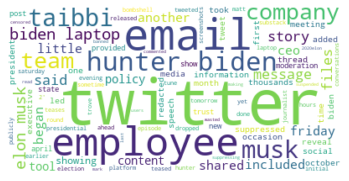

In [60]:
# create wordcloud from one single article 

# Start with one review:
text = df_eda.headline_body[0]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [61]:
#understand the most common segment categories outside of IAS 

df['segment_name_simplified'].loc[df['taxonomy_name']!='IASBrandSafetyTaxonomyId'].value_counts()

else                             32457
Crime                             3611
Death_and_Injury                  3311
Violence                          1067
Arms                               747
Hatespeech                         530
Military                           480
Celebrity Gossip                   458
Adult                              434
Human-made_Disasters               361
Natural Disasters                  282
Terrorism                          273
Drugs                              253
Negative News: Financial           141
Vehicle Disasters                  118
Alcohol                             86
Aviation Disasters                  40
Obscenity                           20
Tobacco                             17
Negative News: Pharmaceutical       10
Occult                               9
Profanity                            8
All Severe Content                   6
Gambling                             4
Name: segment_name_simplified, dtype: int64

In [62]:
#define text to explore excluding IAS and looking at "Adult" category only

t = df['headline_body'].loc[(df['taxonomy_name']!='IASBrandSafetyTaxonomyId') & (df['segment_name_simplified']=='Adult')]

In [63]:
t = t.unique()

#t[:2]

In [64]:
# understand the most common words in crime, excluding IAS 

t = str(t)

text = t

print ("There are {} words in the combination of all articles categorised as Crime".format(len(text)))


There are 205816 words in the combination of all articles categorised as Crime


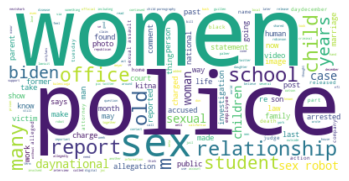

In [65]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["the", "is", "was", "it", "say", "said", "will", "s", "real", "id", "state", "day","mooneshinghe",
                 "moonesinghe","new", "early", "two", "one", "Saturday", "Nov", "Friday", "year", "first", "Warnock",
                 "Walker", "told", "time","three", "second", "t", "FOX NEWS", "n", "u", "people",
                 "according", "FOX", "NEWS"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [66]:
#understand the most common segment categories outside of IAS 

df['segment_name_simplified'].loc[df['taxonomy_name']=='IASBrandSafetyTaxonomyId'].value_counts()

Drugs                  40660
Violence               40660
Offensive Language     40660
Suspicious Activity    40660
Alcohol                40660
Illegal Download       40660
Adult                  40660
Hatespeech             40660
Cannot be rated        20330
Name: segment_name_simplified, dtype: int64

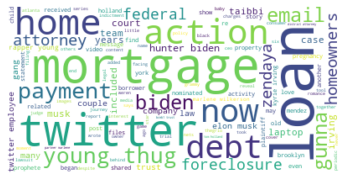

In [67]:
# now "Adult" according to IAS 

#define text to explore excluding IAS and looking at "Crime" category only

t = df['headline_body'].loc[(df['taxonomy_name']=='IASBrandSafetyTaxonomyId') & (df['segment_name_simplified']=='Adult')]

t = t.unique()

# understand the most common words in crime, excluding IAS 

t = str(t)

text = t

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["the", "is", "was", "it", "say", "said", "will", "s", "real", "id", "state", "day","mooneshinghe",
                 "moonesinghe","new", "early", "two", "one", "Saturday", "Nov", "Friday", "year", "first", "Warnock",
                 "Walker", "told", "time","three", "second", "t", "FOX NEWS", "n", "u", "people",
                 "according", "FOX", "NEWS"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now check the most common words in "Adult" articles according to IAS

In [68]:
#define text to explore 

t = df['body'].loc[(df['taxonomy_name']=='IASBrandSafetyTaxonomyId') & (df['segment_name_simplified']=='Adult')]

In [69]:
t = t.unique()

# understand the most common words in crime with IAS 

t = str(t)

text = t

print ("There are {} words in the combination of all articles categorised as Adult".format(len(text)))


There are 17884 words in the combination of all articles categorised as Adult


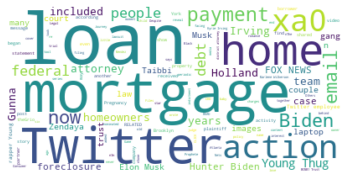

In [70]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["the", "is", "was", "it", "say", "said", "will", "s", "real", "id", "state", "day","mooneshinghe",
                 "moonesinghe","new", "early", "two", "one", "Saturday", "Nov", "Friday", "year", "first", "Warnock",
                 "Walker", "told", "time","three", "second"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let's check adult excluding IAS

In [71]:
#define text to explore 

t = df['body'].loc[(df['taxonomy_name']!='IASBrandSafetyTaxonomyId') & (df['segment_name_simplified']=='Adult')]

t = t.unique()

# understand the most common words in Adult, excluding IAS 

t = str(t)

text = t

print ("There are {} words in the combination of all articles categorised as Adult".format(len(text)))



There are 204824 words in the combination of all articles categorised as Adult


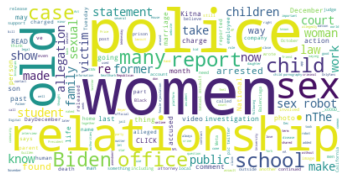

In [72]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["the", "is", "was", "it", "say", "said", "will", "s", "real", "id", "state", "day","mooneshinghe",
                 "moonesinghe","new", "early", "two", "one", "Saturday", "Nov", "Friday", "year", "first", "Warnock",
                 "Walker", "told", "time","three", "second", "t", "FOX NEWS", "n", "u", "people",
                 "according", "FOX", "NEWS", "n_x000D_", "n_x000D_", "The", "DayNational", "m", "years"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Add more views of common nouns, verbs in different categories

In [73]:
df.head(2)

,normalized_url,taxonomy_name,segment_id,segment_name,flag,headline,body,headline_body,lemmas,adjs_verbs,...,content_views,IAS_GS_unsafe_flag,GS_DV_unsafe_flag,IAS_DV_unsafe_flag,IAS_unsafe_flag,GS_unsafe_flag,DV_unsafe_flag,display_revenue,yield_cpm,segment_name_simplified
0,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260090,Exclude content rated as HIGH RISK for Drug Co...,unsafe,NaN,NaN,NaN,NaN,NaN,...,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe,3.56,3.567134,Drugs
1,https://news.yahoo.com/full-press-conference-a...,IASBrandSafetyTaxonomyId,50260104,Exclude content rated as HIGH or MODERATE RISK...,unsafe,NaN,NaN,NaN,NaN,NaN,...,998,unsafe,unsafe,unsafe,unsafe,unsafe,safe,3.56,3.567134,Violence


In [74]:
df.columns.to_list()

['normalized_url',
 'taxonomy_name',
 'segment_id',
 'segment_name',
 'flag',
 'headline',
 'body',
 'headline_body',
 'lemmas',
 'adjs_verbs',
 'nouns',
 'entities',
 'entities_gpe',
 'entities_person',
 'entities_org',
 'content_views',
 'IAS_GS_unsafe_flag',
 'GS_DV_unsafe_flag',
 'IAS_DV_unsafe_flag',
 'IAS_unsafe_flag',
 'GS_unsafe_flag',
 'DV_unsafe_flag',
 'display_revenue',
 'yield_cpm',
 'segment_name_simplified']

Look at the most common entities in unsafe and safe articles according to GS & DV

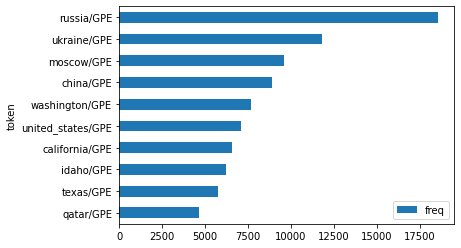

In [89]:
# filter data 

x = df_eda.loc[df_eda['GS_DV_unsafe_flag']=='unsafe']

# display chart with most common entities 

count_words(x, 'entities_gpe').head(10).plot(kind='barh').invert_yaxis()


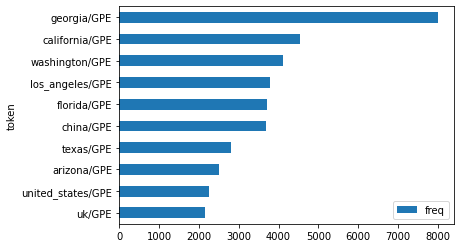

In [90]:
# filter data 

x = df_eda.loc[df_eda['GS_DV_unsafe_flag']=='safe']

# display chart with most common entities 

count_words(x, 'entities_gpe').head(10).plot(kind='barh').invert_yaxis()


In [77]:
# how more likely is that an article containing Russia is labeled as "unsafe"

# filter data for articles containing "Russia"
russia_articles = df_eda.loc[df_eda['headline_body'].str.contains('russia')]

# calculate frequency of articles containing "Russia" in the "unsafe" and "safe" categories
unsafe_freq = len(russia_articles.loc[russia_articles['GS_DV_unsafe_flag'] == 'unsafe'])
safe_freq = len(russia_articles.loc[russia_articles['GS_DV_unsafe_flag'] == 'safe'])

# calculate proportion of "unsafe" articles and "safe" articles that contain "Russia"
unsafe_prop = unsafe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'unsafe'])
safe_prop = safe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'safe'])

# calculate the ratio of the proportions to get the relative likelihood of an article containing "Russia" being labeled as "unsafe" compared to "safe"
likelihood_ratio = unsafe_prop / safe_prop

print(f"The relative likelihood of an article containing 'Russia' being labeled as 'unsafe' compared to 'safe' is {likelihood_ratio:.2f}")
print(f"Frequency of 'Russia' articles labeled as unsafe {unsafe_freq:.2f}")
print(f"Frequency of 'Russia' articles labeled as safe {safe_freq:.2f}")
print(f"Proportion of russia unsafe articles in unsafe articles {unsafe_prop:.2f}")
print(f"Proportion of russia safe articles in safe articles {safe_prop:.2f}")



The relative likelihood of an article containing 'Russia' being labeled as 'unsafe' compared to 'safe' is 2.48
Frequency of 'Russia' articles labeled as unsafe 6050.00
Frequency of 'Russia' articles labeled as safe 1364.00
Proportion of russia unsafe articles in unsafe articles 0.19
Proportion of russia safe articles in safe articles 0.08


In [78]:
# how more likely is that an article containing Russia is labeled as "unsafe"

# filter data for articles containing focus word
focus_articles = df_eda.loc[df_eda['headline_body'].str.contains('ukraine')]

# calculate frequency of articles containing focus word in the "unsafe" and "safe" categories
unsafe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'unsafe'])
safe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'safe'])

# calculate proportion of "unsafe" articles and "safe" articles that contain focus word
unsafe_prop = unsafe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'unsafe'])
safe_prop = safe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'safe'])

# calculate the ratio of the proportions to get the relative likelihood of an article containing focus word being labeled as "unsafe" compared to "safe"
likelihood_ratio = unsafe_prop / safe_prop

print(f"The relative likelihood of an article containing 'Ukraine' being labeled as 'unsafe' compared to 'safe' is {likelihood_ratio:.2f}")
print(f"Frequency of 'Ukraine' articles labeled as unsafe {unsafe_freq:.2f}")
print(f"Frequency of 'Ukraine' articles labeled as safe {safe_freq:.2f}")
print(f"Proportion of Ukraine unsafe articles in unsafe articles {unsafe_prop:.2f}")
print(f"Proportion of Ukraine safe articles in safe articles {safe_prop:.2f}")



The relative likelihood of an article containing 'Ukraine' being labeled as 'unsafe' compared to 'safe' is 2.70
Frequency of 'Ukraine' articles labeled as unsafe 5208.00
Frequency of 'Ukraine' articles labeled as safe 1078.00
Proportion of Ukraine unsafe articles in unsafe articles 0.17
Proportion of Ukraine safe articles in safe articles 0.06


In [79]:
# how more likely is that an article containing Russia is labeled as "unsafe"

# filter data for articles containing focus word
focus_articles = df_eda.loc[df_eda['headline_body'].str.contains('moscow')]

# calculate frequency of articles containing focus word in the "unsafe" and "safe" categories
unsafe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'unsafe'])
safe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'safe'])

# calculate proportion of "unsafe" articles and "safe" articles that contain focus word
unsafe_prop = unsafe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'unsafe'])
safe_prop = safe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'safe'])

# calculate the ratio of the proportions to get the relative likelihood of an article containing focus word being labeled as "unsafe" compared to "safe"
likelihood_ratio = unsafe_prop / safe_prop

print(f"The relative likelihood of an article containing 'Ukraine' being labeled as 'unsafe' compared to 'safe' is {likelihood_ratio:.2f}")
print(f"Frequency of 'Ukraine' articles labeled as unsafe {unsafe_freq:.2f}")
print(f"Frequency of 'Ukraine' articles labeled as safe {safe_freq:.2f}")
print(f"Proportion of Ukraine unsafe articles in unsafe articles {unsafe_prop:.2f}")
print(f"Proportion of Ukraine safe articles in safe articles {safe_prop:.2f}")



The relative likelihood of an article containing 'Ukraine' being labeled as 'unsafe' compared to 'safe' is 4.60
Frequency of 'Ukraine' articles labeled as unsafe 2721.00
Frequency of 'Ukraine' articles labeled as safe 331.00
Proportion of Ukraine unsafe articles in unsafe articles 0.09
Proportion of Ukraine safe articles in safe articles 0.02


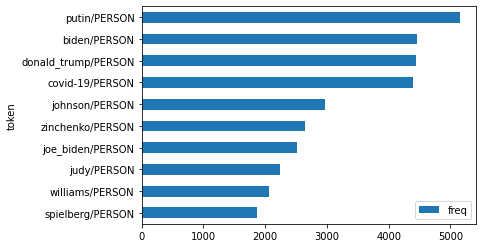

In [80]:
# filter data 

x = df_eda.loc[df_eda['GS_DV_unsafe_flag']=='unsafe']

# display chart with most common entities 

count_words(x, 'entities_person').head(10).plot(kind='barh').invert_yaxis()


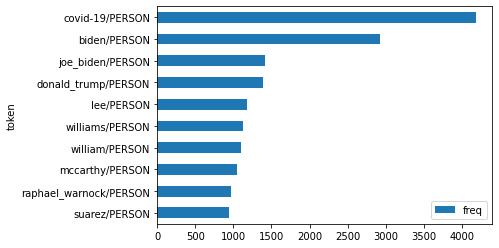

In [81]:
# filter data 

x = df_eda.loc[df_eda['GS_DV_unsafe_flag']=='safe']

# display chart with most common entities 

count_words(x, 'entities_person').head(10).plot(kind='barh').invert_yaxis()


In [82]:
# how more likely is that an article containing Russia is labeled as "unsafe"

# filter data for articles containing focus word
focus_articles = df_eda.loc[df_eda['headline_body'].str.contains('putin')]

# calculate frequency of articles containing focus word in the "unsafe" and "safe" categories
unsafe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'unsafe'])
safe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'safe'])

# calculate proportion of "unsafe" articles and "safe" articles that contain focus word
unsafe_prop = unsafe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'unsafe'])
safe_prop = safe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'safe'])

# calculate the ratio of the proportions to get the relative likelihood of an article containing focus word being labeled as "unsafe" compared to "safe"
likelihood_ratio = unsafe_prop / safe_prop

print(f"The relative likelihood of an article containing 'Putin' being labeled as 'unsafe' compared to 'safe' is {likelihood_ratio:.2f}")
print(f"Frequency of 'Putin' articles labeled as unsafe {unsafe_freq:.2f}")
print(f"Frequency of 'Putin' articles labeled as safe {safe_freq:.2f}")
print(f"Proportion of Putin unsafe articles in unsafe articles {unsafe_prop:.2f}")
print(f"Proportion of Putin safe articles in safe articles {safe_prop:.2f}")



The relative likelihood of an article containing 'Putin' being labeled as 'unsafe' compared to 'safe' is 3.58
Frequency of 'Putin' articles labeled as unsafe 2133.00
Frequency of 'Putin' articles labeled as safe 334.00
Proportion of Putin unsafe articles in unsafe articles 0.07
Proportion of Putin safe articles in safe articles 0.02


In [84]:
# how more likely is that an article containing Russia is labeled as "unsafe"

# filter data for articles containing focus word
focus_articles = df_eda.loc[df_eda['headline_body'].str.contains('donald trump')]

# calculate frequency of articles containing focus word in the "unsafe" and "safe" categories
unsafe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'unsafe'])
safe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'safe'])

# calculate proportion of "unsafe" articles and "safe" articles that contain focus word
unsafe_prop = unsafe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'unsafe'])
safe_prop = safe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'safe'])

# calculate the ratio of the proportions to get the relative likelihood of an article containing focus word being labeled as "unsafe" compared to "safe"
likelihood_ratio = unsafe_prop / safe_prop

print(f"The relative likelihood of an article containing 'Donald Trump' being labeled as 'unsafe' compared to 'safe' is {likelihood_ratio:.2f}")
print(f"Frequency of 'Donald Trump' articles labeled as unsafe {unsafe_freq:.2f}")
print(f"Frequency of 'Donald Trump' articles labeled as safe {safe_freq:.2f}")
print(f"Proportion of Donald Trump unsafe articles in unsafe articles {unsafe_prop:.2f}")
print(f"Proportion of Donald Trump safe articles in safe articles {safe_prop:.2f}")



The relative likelihood of an article containing 'Donald Trump' being labeled as 'unsafe' compared to 'safe' is 1.14
Frequency of 'Donald Trump' articles labeled as unsafe 3143.00
Frequency of 'Donald Trump' articles labeled as safe 1540.00
Proportion of Donald Trump unsafe articles in unsafe articles 0.10
Proportion of Donald Trump safe articles in safe articles 0.09


In [86]:
# how more likely is that an article containing Russia is labeled as "unsafe"

# filter data for articles containing focus word
focus_articles = df_eda.loc[df_eda['headline_body'].str.contains('biden')]

# calculate frequency of articles containing focus word in the "unsafe" and "safe" categories
unsafe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'unsafe'])
safe_freq = len(focus_articles.loc[focus_articles['GS_DV_unsafe_flag'] == 'safe'])

# calculate proportion of "unsafe" articles and "safe" articles that contain focus word
unsafe_prop = unsafe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'unsafe'])
safe_prop = safe_freq / len(df_eda.loc[df_eda['GS_DV_unsafe_flag'] == 'safe'])

# calculate the ratio of the proportions to get the relative likelihood of an article containing focus word being labeled as "unsafe" compared to "safe"
likelihood_ratio = unsafe_prop / safe_prop

print(f"The relative likelihood of an article containing 'Biden' being labeled as 'unsafe' compared to 'safe' is {likelihood_ratio:.2f}")
print(f"Frequency of 'Biden' articles labeled as unsafe {unsafe_freq:.2f}")
print(f"Frequency of 'Biden' articles labeled as safe {safe_freq:.2f}")
print(f"Proportion of Biden unsafe articles in unsafe articles {unsafe_prop:.2f}")
print(f"Proportion of Biden safe articles in safe articles {safe_prop:.2f}")



The relative likelihood of an article containing 'Biden' being labeled as 'unsafe' compared to 'safe' is 1.00
Frequency of 'Biden' articles labeled as unsafe 4760.00
Frequency of 'Biden' articles labeled as safe 2677.00
Proportion of Biden unsafe articles in unsafe articles 0.15
Proportion of Biden safe articles in safe articles 0.15


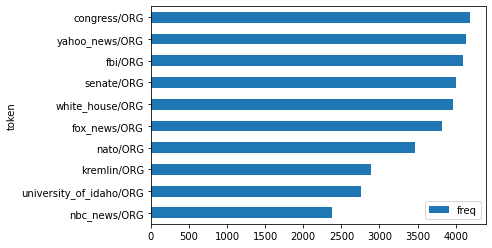

In [87]:
# filter data 

x = df_eda.loc[df_eda['GS_DV_unsafe_flag']=='unsafe']

# display chart with most common entities 

count_words(x, 'entities_org').head(10).plot(kind='barh').invert_yaxis()


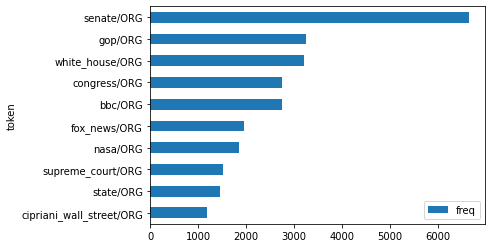

In [88]:
# filter data 

x = df_eda.loc[df_eda['GS_DV_unsafe_flag']=='safe']

# display chart with most common entities 

count_words(x, 'entities_org').head(10).plot(kind='barh').invert_yaxis()
